In [35]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
import librosa
import librosa.display
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier as RandomForest, HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, minmax_scale
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tabulate import tabulate
from pprint import pprint
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/extracted_features_iemocap.csv"
SCALED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/scaled_features_iemocap.csv"
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
RAW_AUDIO_FILES = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/raw_audio_files.csv"
AUDIO_SPECTOGRAMS_DIR = './../data/spectograms/'

config = Configuration.load_json(CONFIG_FILE)

OneHotEncodingConfig = {'0': [1, 0], '1': [0, 1]}
plt.rcParams['figure.dpi'] = 300

In [36]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df[df.columns[8:]] = minmax_scale(df[df.columns[8:]], config.scale_range)
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 0, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 0
# df.loc[df['Emotion'] == 'angry', 'Emotion'] = 'negative'
# df.loc[df['Emotion'] == 'sad', 'Emotion'] = 'negative'
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 1
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
# df.loc[df['Emotion'] == 'happy', 'Emotion'] = 'positive'
# df.loc[df['Emotion'] == 'neutral', 'Emotion'] = 'positive'
# df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'positive'
print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion_Id']).agg({'Emotion_Id': ['count']})

Number of Audio Files: 5531


,Emotion_Id
,count
Emotion_Id,
0,2811
1,2720


In [37]:
def get_metrics(y_labels, y_pred, draw_corr_matrix=True):
    folds_size = 1107
    accs = []
    i = 0
    for f_i in range(5):
        if f_i == 1:
            folds_size -= 1
        acc = round(metrics.accuracy_score(
            y_labels[i:i+folds_size], y_pred[i:i+folds_size]) * 100, 2)
        print(f"Accuracy for fold {f_i}: {acc}%")
        i += folds_size
        accs.append(acc)

    table = [
        ["Accuracy",
            f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}+-{round(np.std(accs), 2)}"],
        ["F1 score macro", round(metrics.f1_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(
            metrics.matthews_corrcoef(y_labels, y_pred), 3)],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))

    if draw_corr_matrix:
        ticks = ['0 - negative', '1 - positive']
        cm = metrics.confusion_matrix(y_labels, y_pred)
        plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()

def categorical_cross_validation(get_new_model, cv=5, draw_corr_matrix=True):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    
    X = df.iloc[:,8:]
    y = df.iloc[:,4:5]
    all_y_pred = []
    all_y_labels = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)

Accuracy for fold 0: 69.56%
Accuracy for fold 1: 71.52%
Accuracy for fold 2: 69.26%
Accuracy for fold 3: 71.25%
Accuracy for fold 4: 71.07%

Metric             Value
-----------------  -----------
Accuracy           70.53+-0.93
F1 score macro     70.41
Precision          70.69
Recall             70.45
Matthews corrcoef  0.411


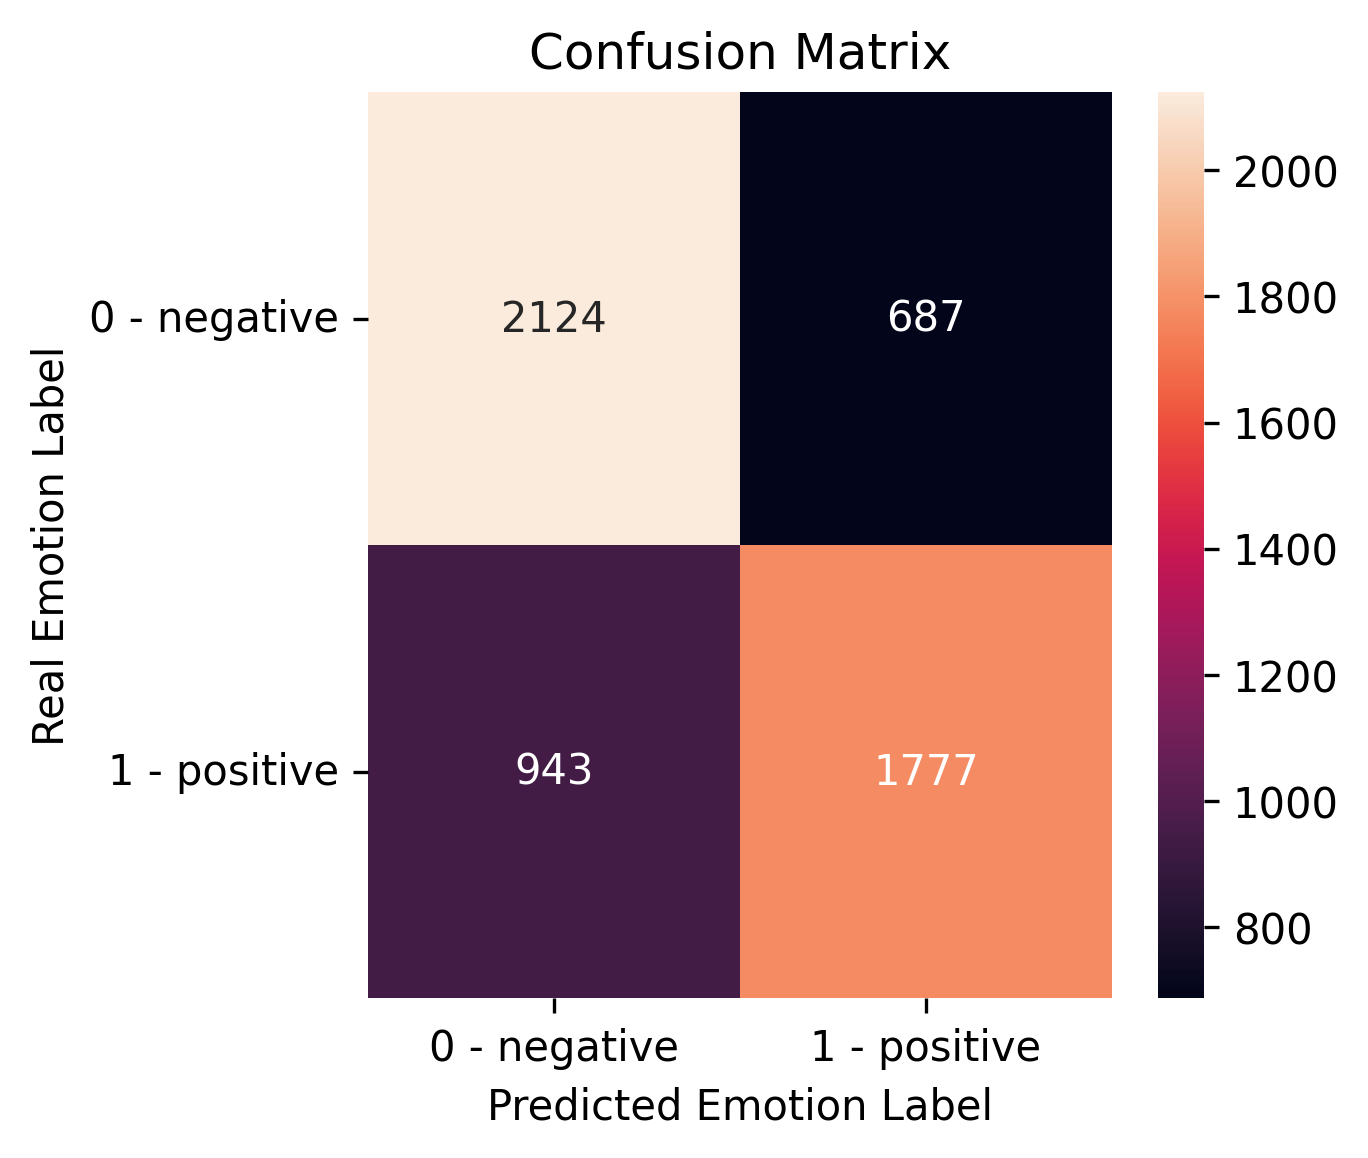

In [38]:
def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
categorical_cross_validation(get_new_model)

Accuracy for fold 0: 67.75%
Accuracy for fold 1: 68.63%
Accuracy for fold 2: 67.45%
Accuracy for fold 3: 67.36%
Accuracy for fold 4: 67.09%

Metric             Value
-----------------  -----------
Accuracy           67.66+-0.53
F1 score macro     67.62
Precision          67.66
Recall             67.62
Matthews corrcoef  0.353


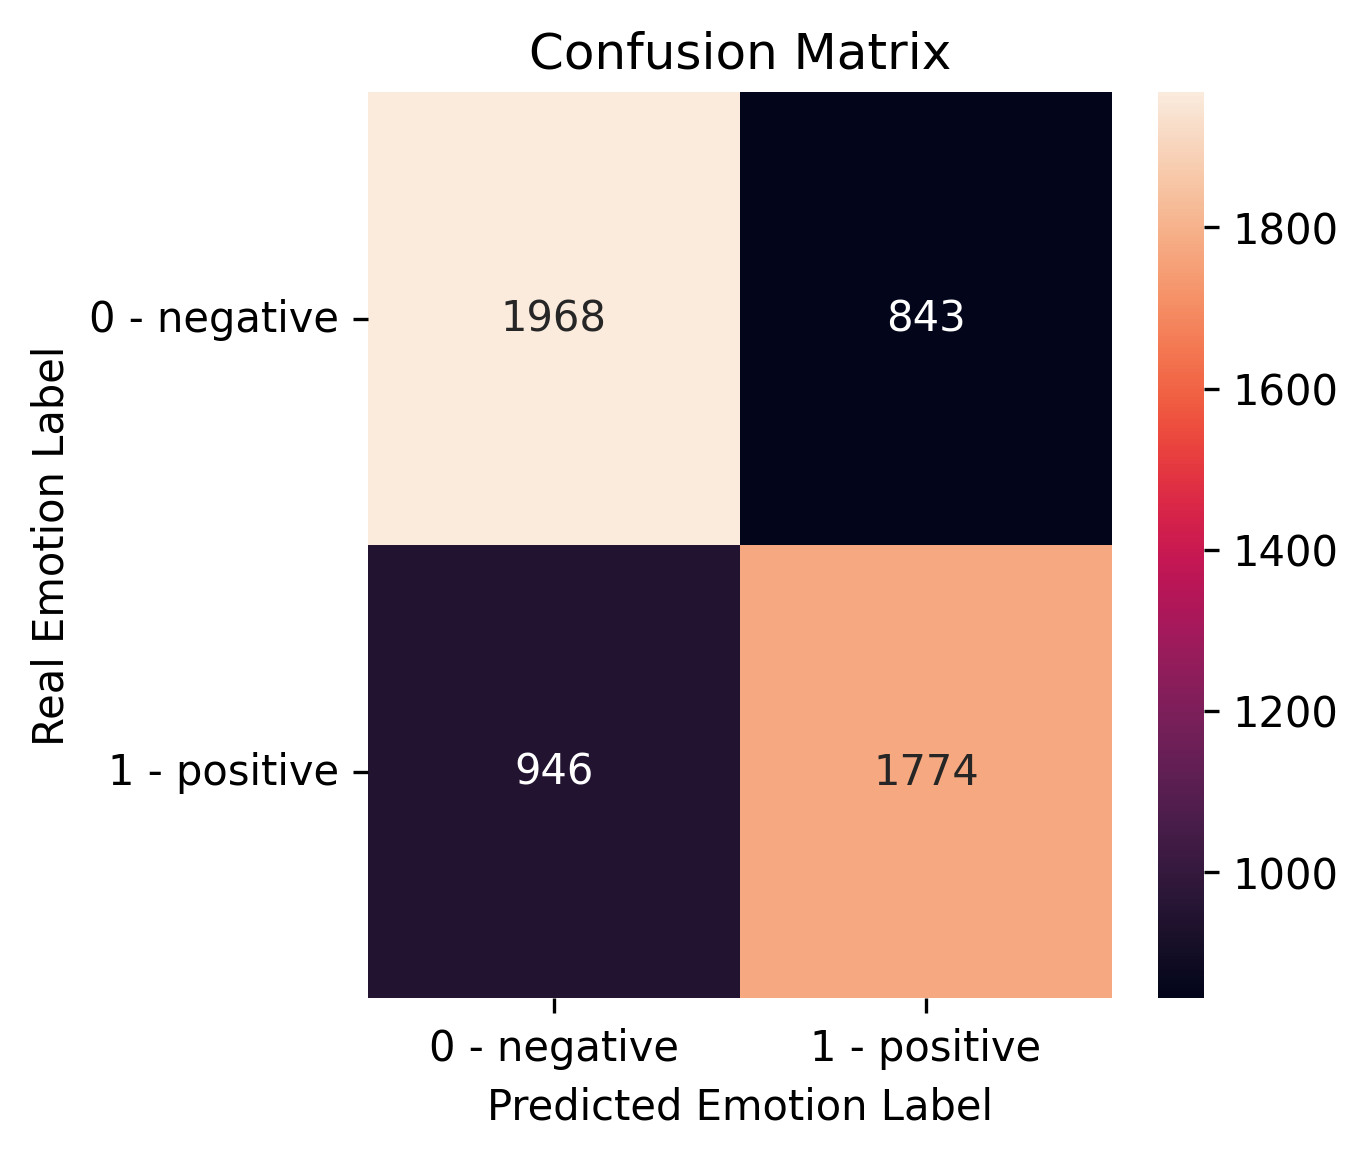

In [39]:
def get_new_model():
    return GradientBoostingClassifier(random_state=1, max_features=8)
categorical_cross_validation(get_new_model)

Accuracy for fold 0: 69.2%
Accuracy for fold 1: 71.16%
Accuracy for fold 2: 69.44%
Accuracy for fold 3: 70.61%
Accuracy for fold 4: 69.98%

Metric             Value
-----------------  -----------
Accuracy           70.08+-0.73
F1 score macro     69.95
Precision          70.25
Recall             69.99
Matthews corrcoef  0.402


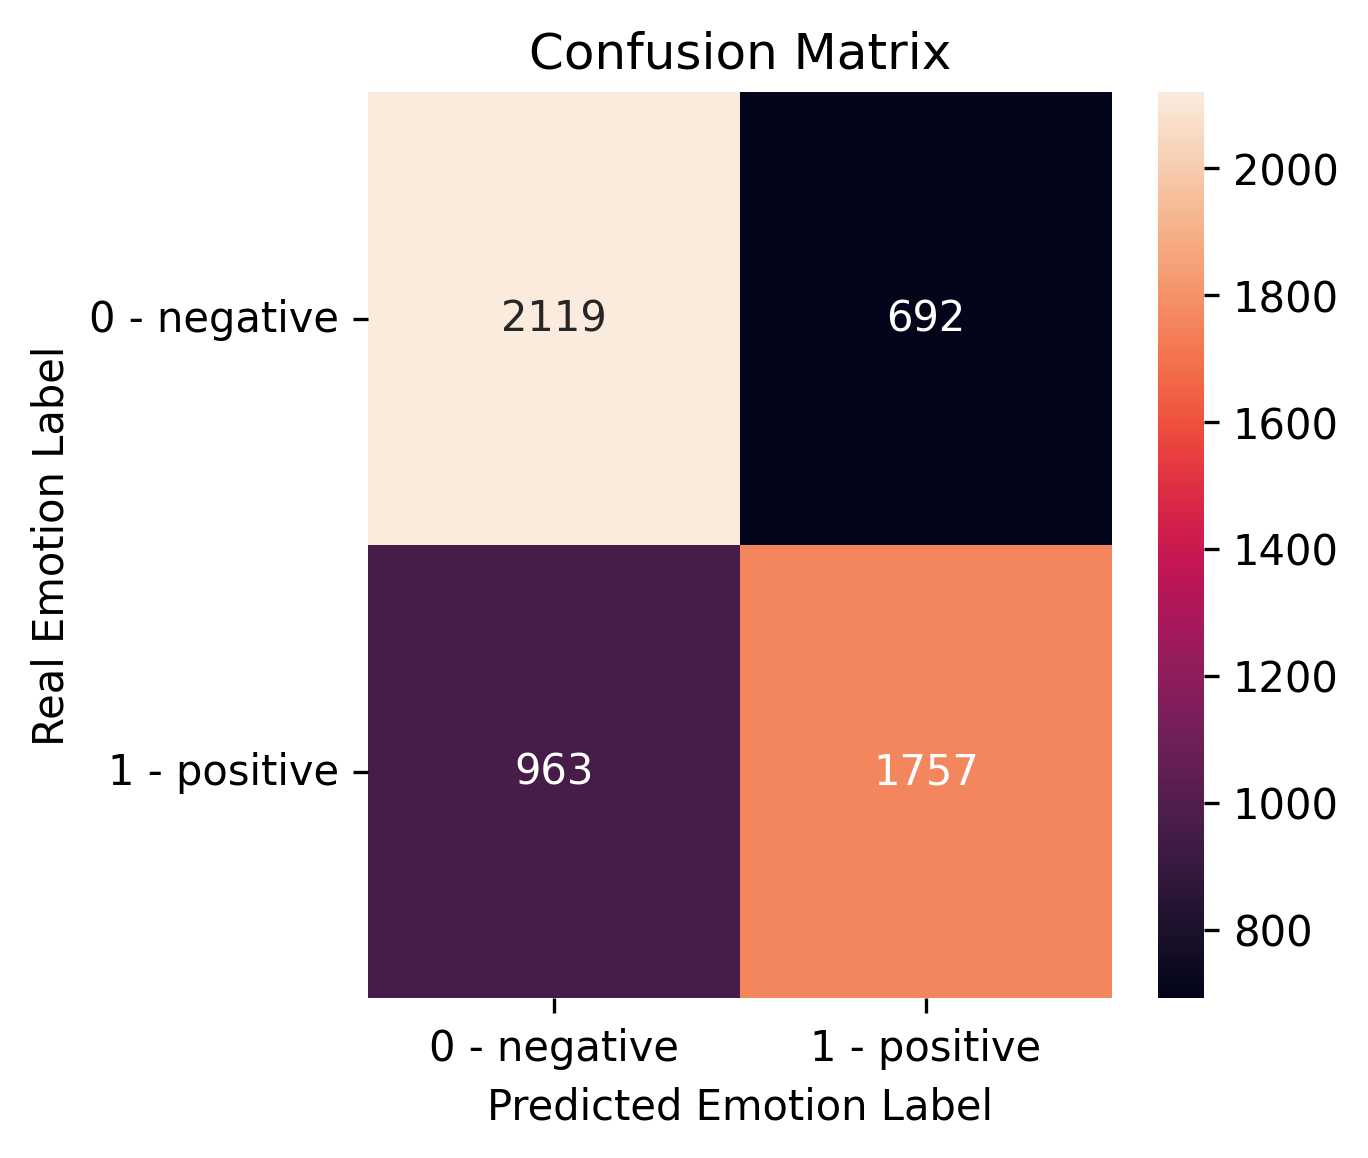

In [40]:
def get_new_model():
    return AdaBoostClassifier(random_state=1, base_estimator=RandomForest(n_estimators=512, n_jobs=-1, random_state=1))
categorical_cross_validation(get_new_model)


Accuracy for fold 0: 68.93%
Accuracy for fold 1: 71.88%
Accuracy for fold 2: 69.8%
Accuracy for fold 3: 68.81%
Accuracy for fold 4: 69.71%

Metric             Value
-----------------  ----------
Accuracy           69.82+-1.1
F1 score macro     69.75
Precision          69.89
Recall             69.76
Matthews corrcoef  0.397


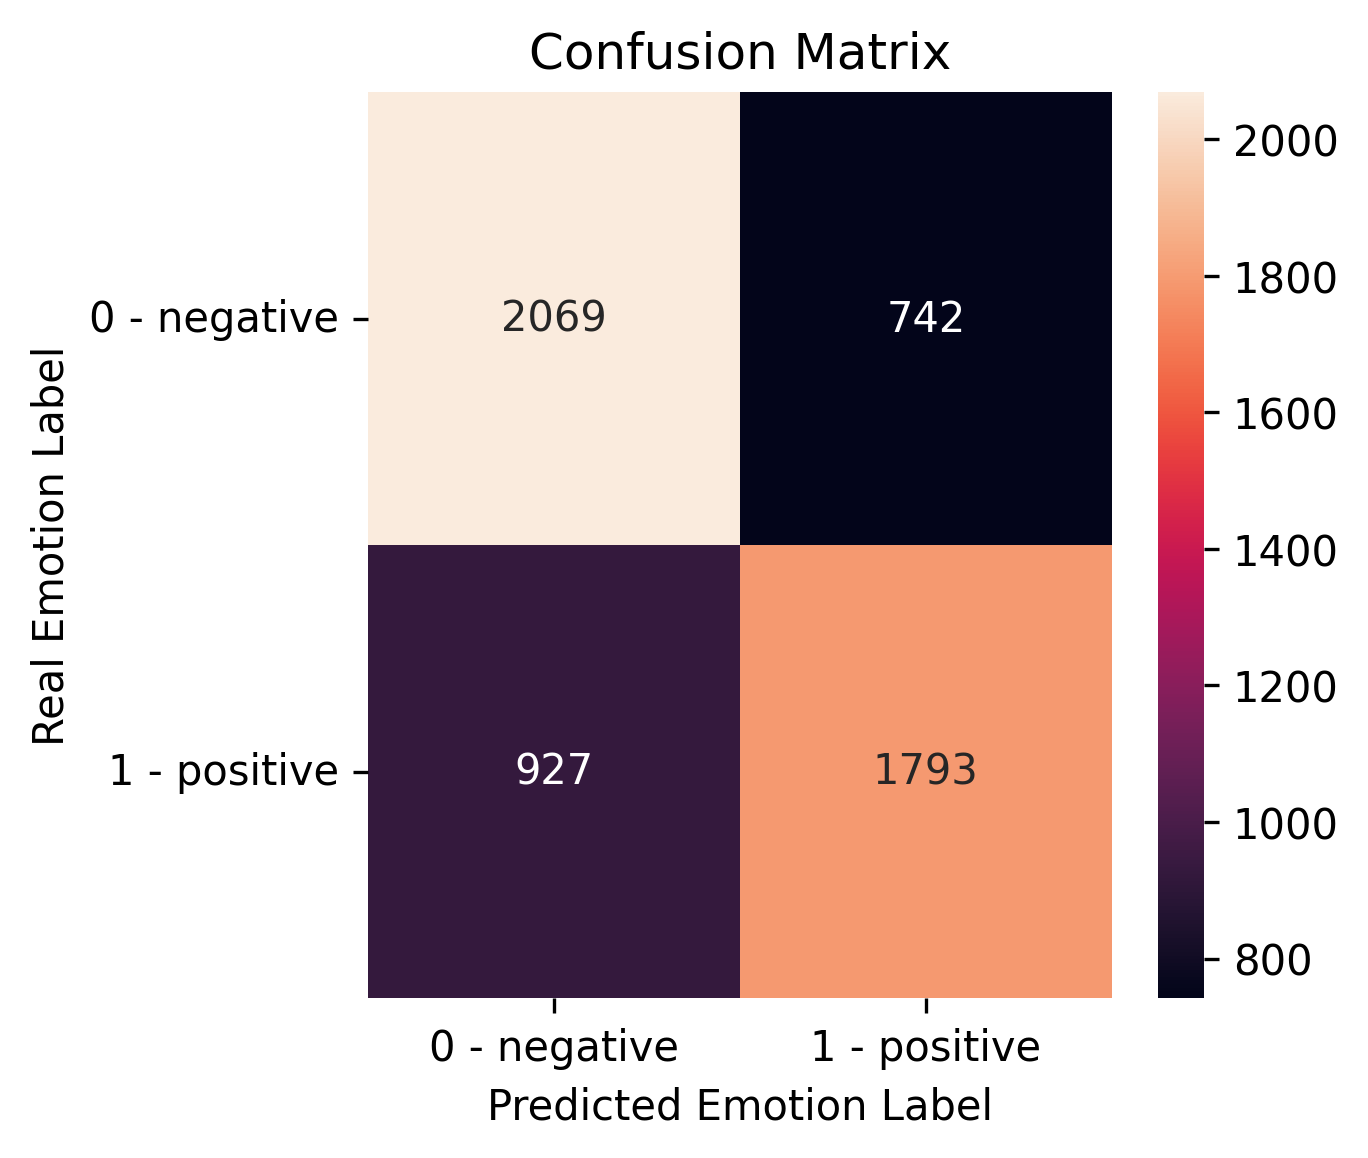

In [41]:
def get_new_model():
    return BalancedRandomForestClassifier(random_state=1, max_features=8)
categorical_cross_validation(get_new_model)

Accuracy for fold 0: 69.56%
Accuracy for fold 1: 71.52%
Accuracy for fold 2: 69.26%
Accuracy for fold 3: 71.25%
Accuracy for fold 4: 71.07%

Metric             Value
-----------------  -----------
Accuracy           70.53+-0.93
F1 score macro     70.41
Precision          70.69
Recall             70.45
Matthews corrcoef  0.411


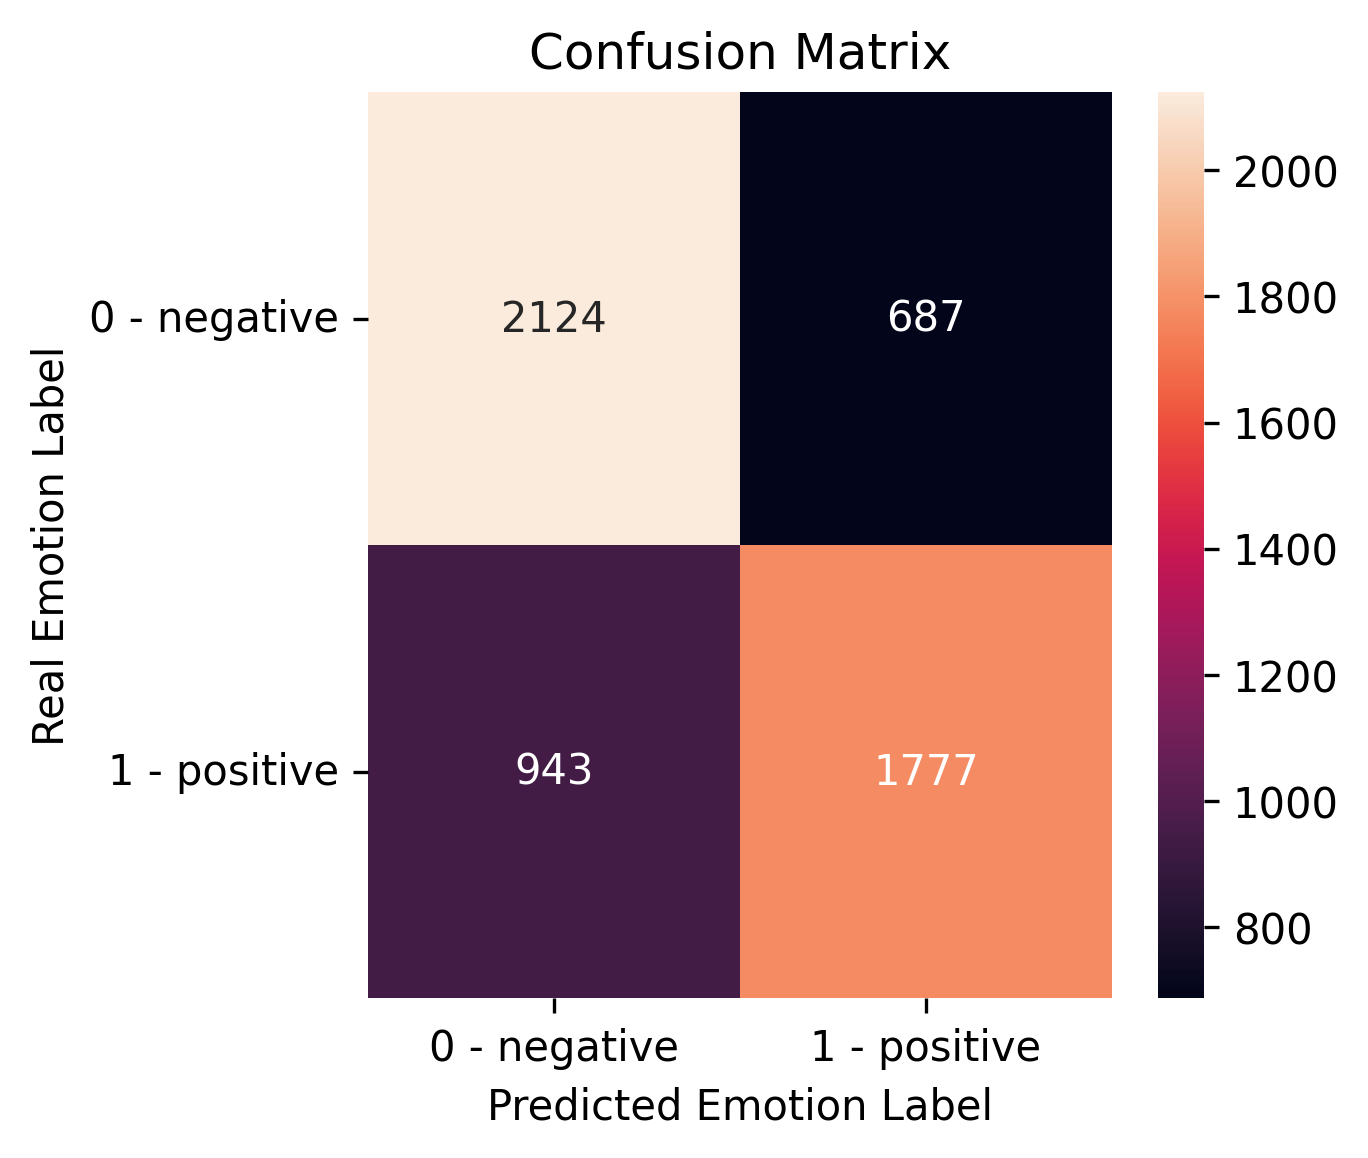

In [42]:
def get_new_model():
  return RandomForest(max_features=4, n_estimators=512, n_jobs=-1,
                       random_state=1, warm_start=True)
categorical_cross_validation(get_new_model)

Accuracy for fold 0: 62.15%
Accuracy for fold 1: 64.65%
Accuracy for fold 2: 61.21%
Accuracy for fold 3: 64.01%
Accuracy for fold 4: 65.73%

Metric             Value
-----------------  -----------
Accuracy           63.55+-1.65
F1 score macro     63.55
Precision          63.56
Recall             63.56
Matthews corrcoef  0.271


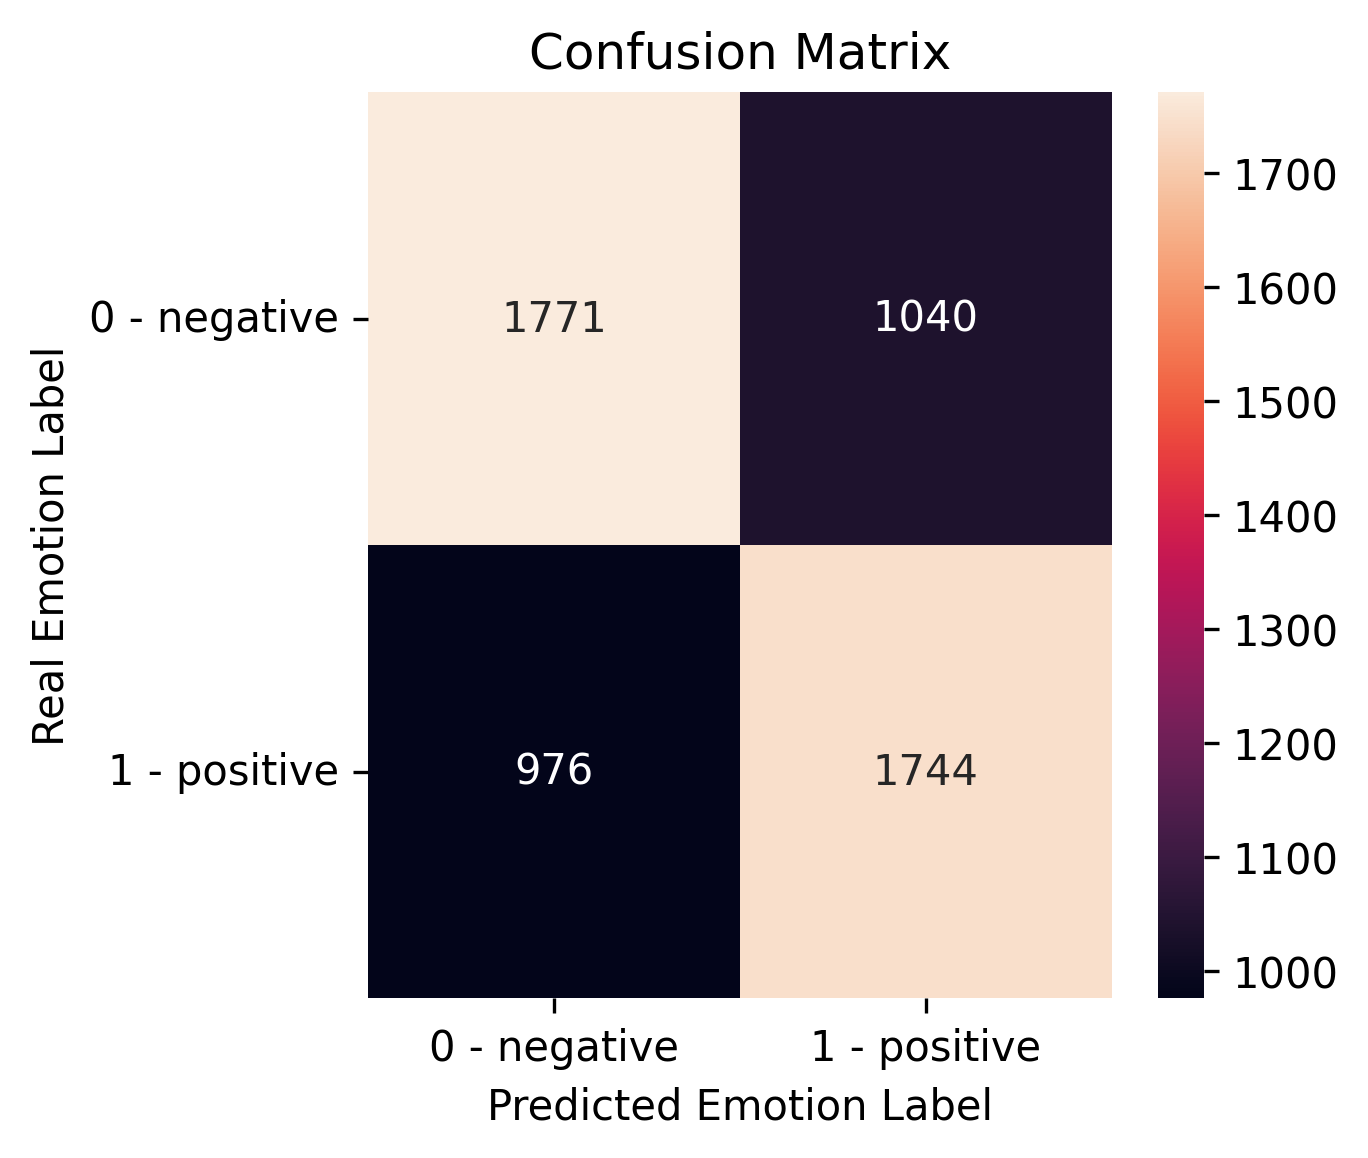

In [43]:
def get_new_model():
    return LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr',
                           tol=0.00010000000000000009)
categorical_cross_validation(get_new_model)

Accuracy for fold 0: 68.29%
Accuracy for fold 1: 68.54%
Accuracy for fold 2: 68.81%
Accuracy for fold 3: 68.54%
Accuracy for fold 4: 70.16%

Metric             Value
-----------------  -----------
Accuracy           68.87+-0.67
F1 score macro     68.83
Precision          68.88
Recall             68.83
Matthews corrcoef  0.377


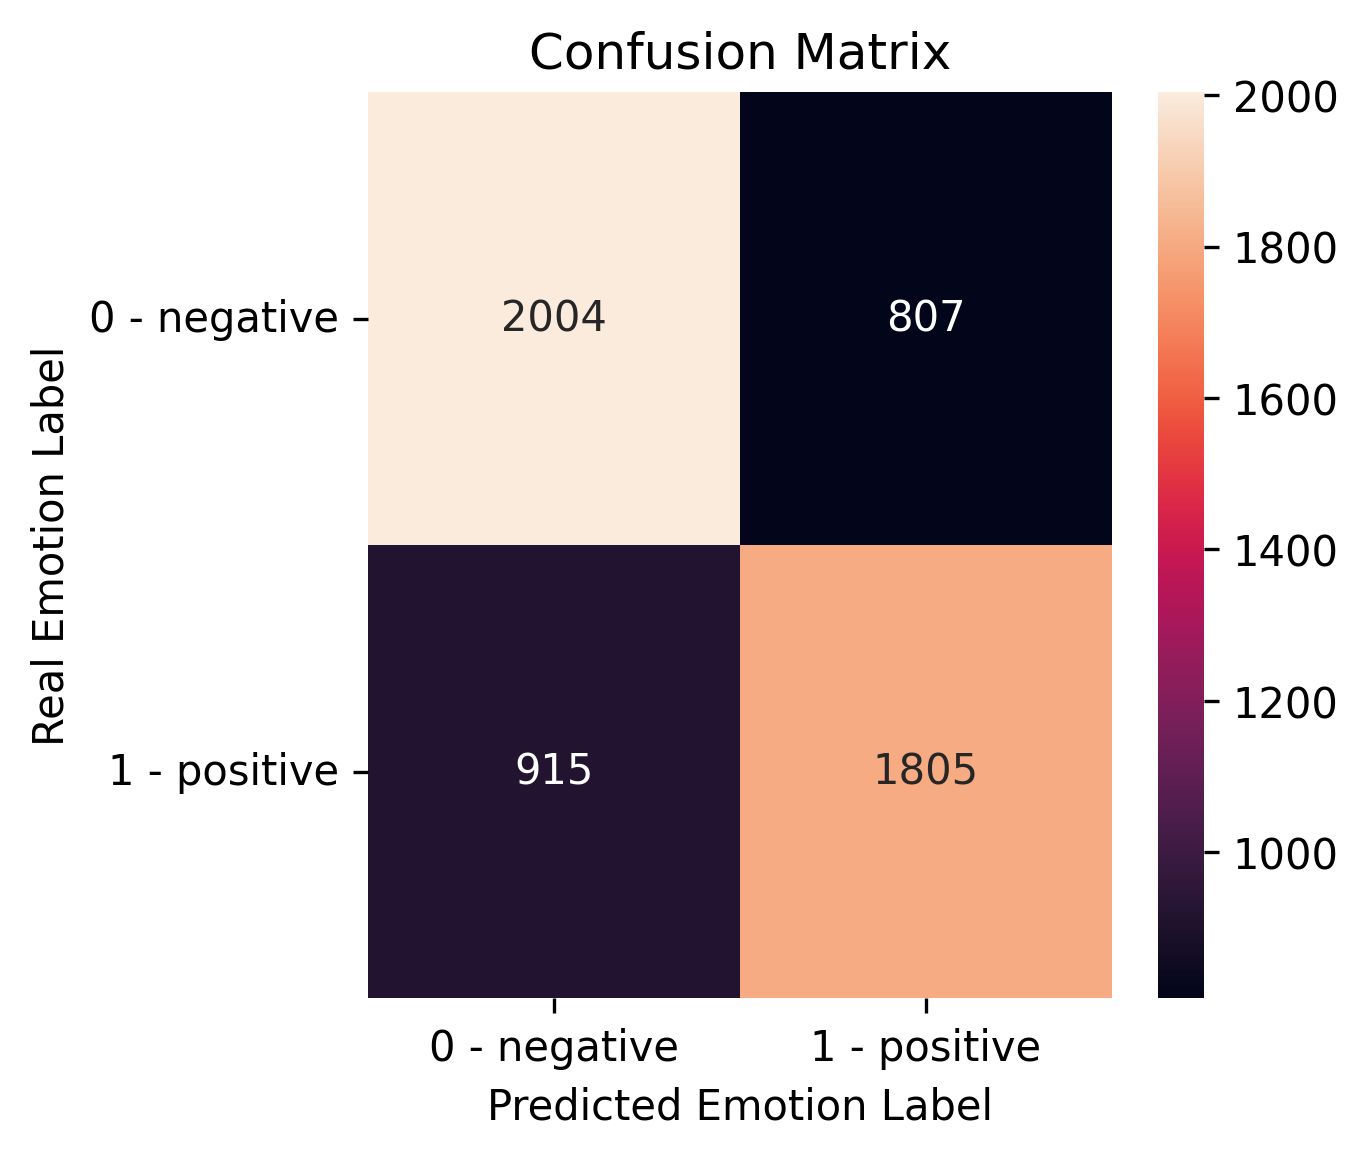

In [44]:
def get_new_model():
    return HistGradientBoostingClassifier(early_stopping=False,
                                          l2_regularization=2.188553300996835e-10,
                                          learning_rate=0.06138190336151616, max_iter=512,
                                          max_leaf_nodes=20, n_iter_no_change=0,
                                          random_state=1, validation_fraction=None,
                                          warm_start=True)
categorical_cross_validation(get_new_model)

Model: "sequential_6"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 lstm_6 (LSTM)               (None, 123)               61500     Y          
                                                                            
 dense_18 (Dense)            (None, 64)                7936      Y          
                                                                            
 dropout_12 (Dropout)        (None, 64)                0         Y          
                                                                            
 dense_19 (Dense)            (None, 32)                2080      Y          
                                                                            
 dropout_13 (Dropout)        (None, 32)                0         Y          
                                                                            
 dense_20 (Dense)            (None, 4)                

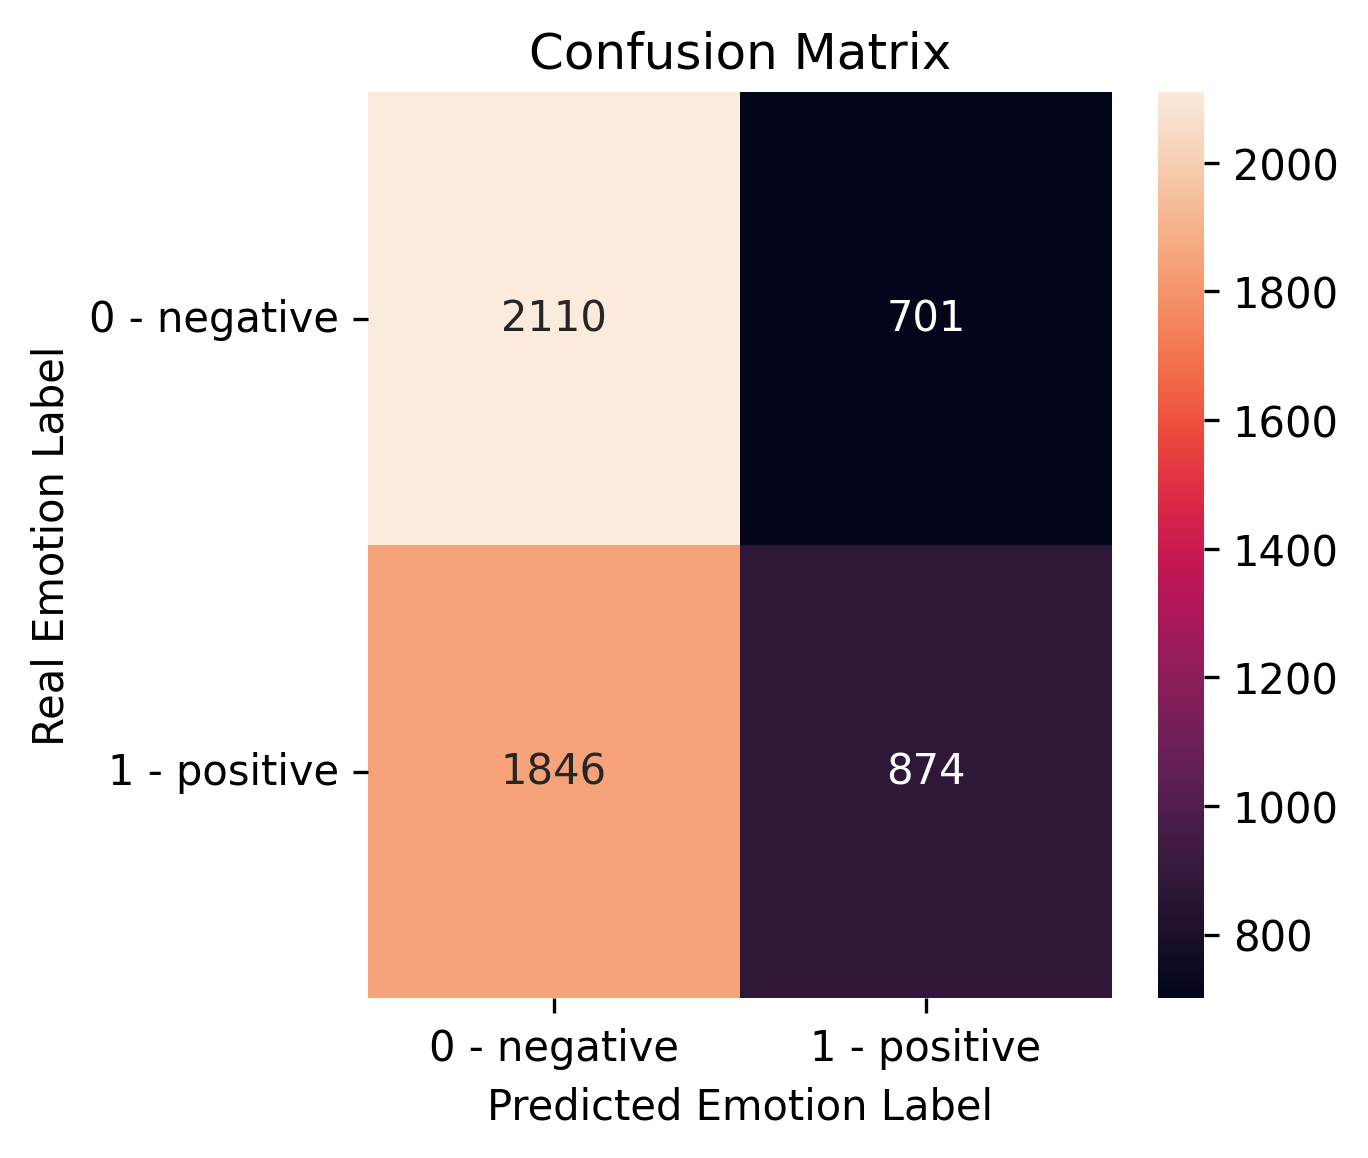

In [45]:
def build_model_1(input_shape=(24, 1), loss=SparseCategoricalCrossentropy(), optimizer=Adam(learning_rate=1e-5, epsilon=1e-6)):
    model = Sequential([
        LSTM(123, return_sequences=False, input_shape=(24, 1)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(4, activation='softmax'),
    ])

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model():
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_1(input_shape=(24, 1), loss=loss, optimizer=optimizer)


get_new_model().summary(show_trainable=True)

def categorical_cross_validation(get_new_model, callbacks, no_epochs, batch_size, verbosity=1, num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1

  X = df.iloc[:, 8:]
  y = df.iloc[:, 4:5]

  all_y_pred = []
  all_y_labels = []

  for train, test in kfold.split(X, y):
    model = get_new_model()

    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=callbacks,
              workers=8)

    y_pred = model.predict(X_test)
    y_pred = [list(x).index(max(x)) for x in y_pred]
    all_y_pred.extend(y_pred)
    all_y_labels.extend(y_test.values)

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)
  
callback = EarlyStopping(monitor='val_loss', patience=10)
no_epochs = 30
batch_size = 256
verbosity = 0
num_folds = 5

categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)